In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import math

In [111]:
sample = 10

In [23]:
def subsample_flatten(df, sample_rate = 1):
    arr = df.to_numpy()
    flat_ls = []
    for i, sample in enumerate(arr):
        if sample[0][-5:] == '05:00':
            layer_height = arr[i-59,-1]
            humidity = arr[i-59,-2]
            flat_ls.append(arr[i-59:i+1,1:-2])
            flat_ls[-1] = flat_ls[-1][::sample_rate].flatten('F')
            flat_ls[-1] = np.append(flat_ls[-1], humidity)
            flat_ls[-1] = np.append(flat_ls[-1], layer_height)
            flat_ls[-1] = np.insert(flat_ls[-1], 0, sample[0], axis = 0)
    return pd.DataFrame(np.vstack(flat_ls))

In [24]:
def get_x_y(df_x, df_y, sample_rate):
    flat_df = subsample_flatten(df_x, sample_rate)
    flat_df.rename(columns={0:'date_time'}, inplace=True)
    flat_df['date_time'] = pd.to_datetime(flat_df['date_time'])
    df_y['date_time'] = pd.to_datetime(df_y['date_time'])
    merged_df = pd.merge(flat_df, df_y, on='date_time', how="inner")
    y_vals = merged_df['quality']
    x_vals = merged_df.drop(['date_time', 'quality'], axis = 1)
    x_vals = x_vals.apply(pd.to_numeric)
    return x_vals, y_vals

In [60]:
def get_important_features(model, features, x, y, thresh, features_nums):
    inc = int(60/sample)
    lh_i = 15*inc + 2
    h_i = 15*inc + 1
    
    fs = SelectFromModel(model, threshold = thresh, prefit = True)
    
    selected_f = features[(fs.get_support())]
    selected_f = np.array(selected_f) - 1
    
    num_features = len(selected_f)
    if num_features in feature_nums:
        return None
        
    x = x[:,list(selected_f)]
    
    l, r = 0, inc
    count = 0
    cols = [[] for _ in range(17)]
    col = []
    
    for j in selected_f:
        if j == lh_i:
            cols[16] = [1]*inc
        elif j == h_i:
            cols[15] = [1]*inc
        else:
            if j >= l and j <= r:
                cols[count].append(j)
            if j >= r:
                l += inc
                r += inc
                count += 1
            
    df = pd.DataFrame({j: pd.Series(vals, dtype = ('int32')) for j, vals in enumerate(cols)})
    cv = cross_val_score(xgb.XGBRegressor(), x, y, cv = 3, scoring = ('neg_root_mean_squared_error'))
    
    rmse = round(np.abs(cv.mean()),2)
    
    print(f'{num_features}' + (19-len(str(num_features)))*' ' + f'| {rmse}' + (6 - len(str(rmse)))*' ' + f'| {thresh}')
    #print(f'Threshold = {threshold}')
    
    return num_features, rmse, df

In [68]:
def plot_feature_importances(df, feature_names, num_features, rmse):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(feature_names, list(df.count()))
    ax.set_title(f'Top {round((num_features/((60*15/sample)+2))*100)}% of features with RMSE of {rmse}')
    plt.xlabel('Feature')
    plt.ylabel('Relative importance')
    plt.show()

In [87]:
df_x = pd.read_csv("archive/data_x.csv")
df_y = pd.read_csv("archive/data_y.csv")

# Drop the first 5 rows because there is not enough information before those times
df_x.drop(index=df_x.index[:6], axis=0, inplace=True)

In [112]:
x_vals, y_vals = get_x_y(df_x, df_y, sample)
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size = 0.2)
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [96]:
x_vals.shape

(29184, 302)

In [113]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train_np, y_train_np)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [110]:
# Sample 10

46                 | 11.13 | 0.0019


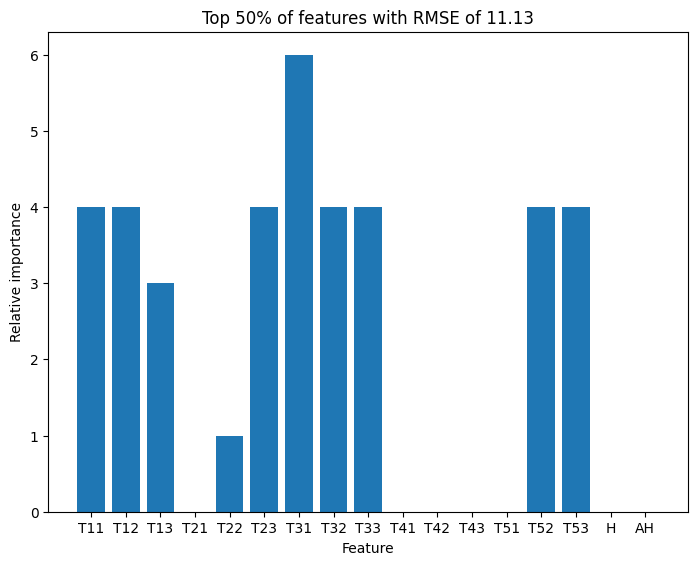

In [134]:
thresh = 0.0019
feature_nums = []
ret = get_important_features(xgb_model, x_train.columns, x_train_np, y_train_np, thresh, feature_nums)
feature_names = ['T11','T12','T13','T21','T22','T23','T31','T32','T33','T41','T42','T43','T51','T52','T53','H','AH']
feature_num, rmse, df = ret
plot_feature_importances(df, feature_names, feature_num, rmse)

In [102]:
# Sample 5

91                 | 10.97 | 0.00065


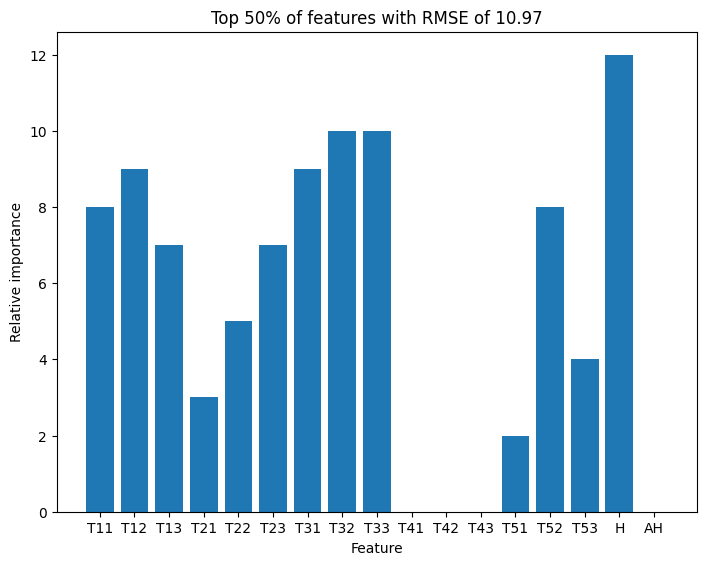

In [109]:
thresh = 0.00065
feature_nums = []
ret = get_important_features(xgb_model, x_train.columns, x_train_np, y_train_np, thresh, feature_nums)
feature_names = ['T11','T12','T13','T21','T22','T23','T31','T32','T33','T41','T42','T43','T51','T52','T53','H','AH']
feature_num, rmse, df = ret
plot_feature_importances(df, feature_names, feature_num, rmse)

In [98]:
# Sample 3

151                | 10.98 | 0.00038


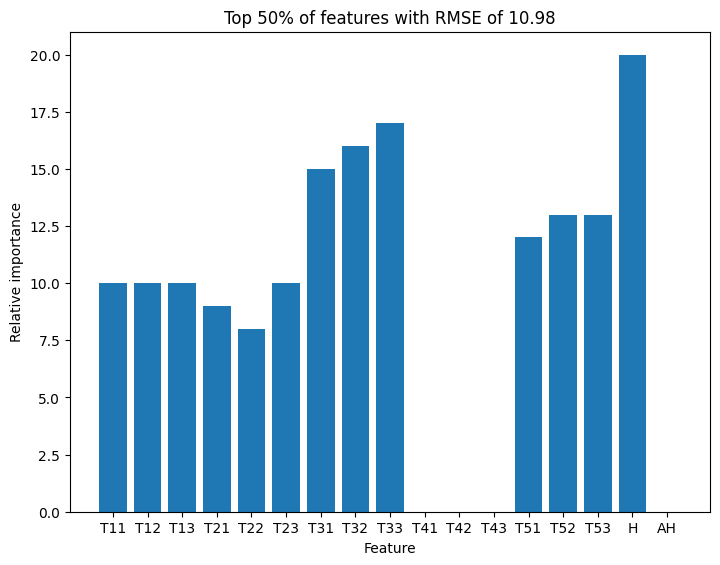

In [101]:
thresh = 0.00038
feature_nums = []
ret = get_important_features(xgb_model, x_train.columns, x_train_np, y_train_np, thresh, feature_nums)
feature_names = ['T11','T12','T13','T21','T22','T23','T31','T32','T33','T41','T42','T43','T51','T52','T53','H','AH']
feature_num, rmse, df = ret
plot_feature_importances(df, feature_names, feature_num, rmse)

In [71]:
# Sample 2

227                | 11.0  | 0.00021


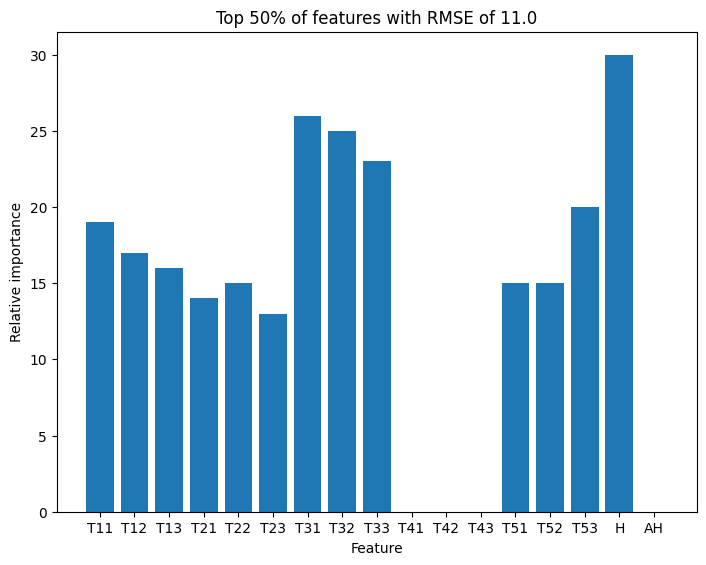

In [75]:
thresh = 0.00021
feature_nums = []
ret = get_important_features(xgb_model, x_train.columns, x_train_np, y_train_np, thresh, feature_nums)
feature_names = ['T11','T12','T13','T21','T22','T23','T31','T32','T33','T41','T42','T43','T51','T52','T53','H','AH']
feature_num, rmse, df = ret
plot_feature_importances(df, feature_names, feature_num, rmse)

In [ ]:
# Sample 1

452                | 11.03 | 8.8e-05


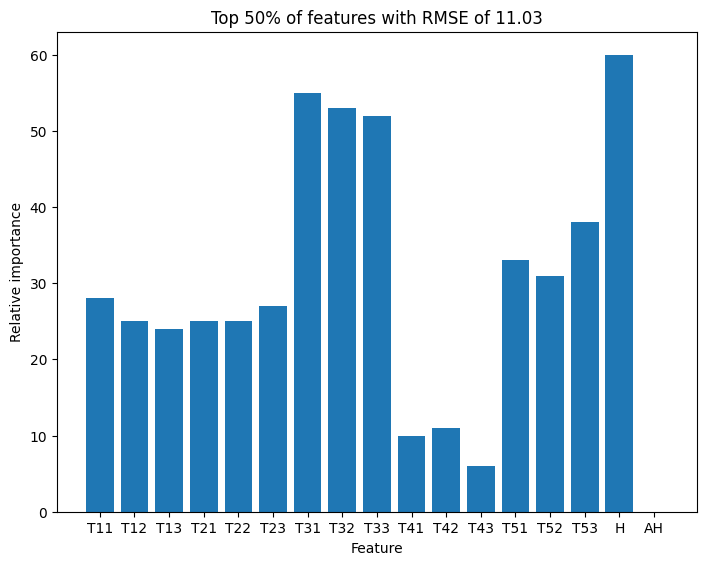

In [93]:
thresh = 0.000088
feature_nums = []
ret = get_important_features(xgb_model, x_train.columns, x_train_np, y_train_np, thresh, feature_nums)
feature_names = ['T11','T12','T13','T21','T22','T23','T31','T32','T33','T41','T42','T43','T51','T52','T53','H','AH']
feature_num, rmse, df = ret
plot_feature_importances(df, feature_names, feature_num, rmse)